<a href="https://colab.research.google.com/github/yongchuu/TensorflowTeam5/blob/main/%ED%85%90%ED%99%9C%EA%B8%B0%EA%B8%B0%EB%A7%90%EA%B3%A0%EC%82%AC(2021_2%ED%95%99%EA%B8%B0)_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Kaggle 데이터셋 다운로드

In [ ]:
## 1. Kaggle 데이터셋 로드
## https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

## /content/kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download alxmamaev/flowers-recognition

! unzip flowers-recognition.zip

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.7.0


## Optional - GPU Setting (local)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # 메모리 증가 허용
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [ ]:
#### 튜토리얼 방식의 이미지 로드

import pathlib
import glob

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
print(data_dir)
images = glob.glob(os.path.join(data_dir, '*', '*'))

/root/.keras/datasets/flower_photos


In [ ]:
import cv2

img_path = '/content/flowers/daisy/100080576_f52e8ee070_n.jpg'
img_path2 = '/content/flowers/daisy/10140303196_b88d3d6cec.jpg'

img = cv2.imread(img_path)
img2 = cv2.imread(img_path2)

print(img.shape)
print(img2.shape)

(263, 320, 3)
(313, 500, 3)


## 1-2. 모델 선택 / input shape
- mobilenetv3_small (256*256)
- mobilenetv3_large (256*256)
- resnet (256*256)
- EfficientNetB0 (224*224)
- EfficientNetB1 (240*240)
- EfficientNetB2 (260*260)
- EfficientNetB3 (300*300)
- EfficientNetB4 (380*380)
- EfficientNetB5 (456*456)
- EfficientNetB6 (528*528)
- EfficientNetB7 (600*600)

In [52]:
# select = ['mobilenetv3_small', 'mobilenetv3_large', 'resnet50', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']
set_model = 'mobilenetv3_small'

## 2. 데이터 셋 생성 (train/ val)

In [53]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

batch_size = 32

input_shape_dic = {
    'mobilenetv3_small': 256,
    'mobilenetv3_large': 256,
    'resnet50': 256,
    'efficientnetb0': 224,
    'efficientnetb1': 240,
    'efficientnetb2': 260,
    'efficientnetb3': 300,
    'efficientnetb4': 380,
    'efficientnetb5': 456,
    'efficientnetb6': 528,
    'efficientnetb7': 600,
}

model_dic = {
    'mobilenetv3_small': tf.keras.applications.MobileNetV3Small,
    'mobilenetv3_large': tf.keras.applications.MobileNetV3Large,
    'resnet50': tf.keras.applications.resnet50.ResNet50,
    'efficientnetb0': tf.keras.applications.efficientnet.EfficientNetB0,
    'efficientnetb1': tf.keras.applications.efficientnet.EfficientNetB1,
    'efficientnetb2': tf.keras.applications.efficientnet.EfficientNetB2,
    'efficientnetb3': tf.keras.applications.efficientnet.EfficientNetB3,
    'efficientnetb4': tf.keras.applications.efficientnet.EfficientNetB4,
    'efficientnetb5': tf.keras.applications.efficientnet.EfficientNetB5,
    'efficientnetb6': tf.keras.applications.efficientnet.EfficientNetB6,
    'efficientnetb7': tf.keras.applications.efficientnet.EfficientNetB7,
}

img_height, img_width = input_shape_dic[set_model], input_shape_dic[set_model]
img_height, img_width

(256, 256)

In [60]:
## tf.keras.preprocessing.image_dataset_from_directory
## https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 
## return tf.data.Dataset

## main_directory/
## ...class_a/
## ......a_image_1.jpg
## ......a_image_2.jpg
## ...class_b/
## ......b_image_1.jpg
## ......b_image_2.jpg

## Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset 
## that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

data_path = '/content/flowers'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="training", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical'
  )


Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [61]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2, # validation_split	Optional float between 0 and 1, fraction of data to reserve for validation.
  subset="validation", # subset	One of "training" or "validation". Only used if validation_split is set.
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [62]:
# resize(224x224) and standardization Layer

resize_layer =  tf.keras.layers.Resizing(img_height, img_width)
# rescale_layer = tf.keras.layers.Rescaling(1./255)

In [63]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

## 3. Model Setting

In [64]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet

if 'mobilenet' in set_model:
  our_model = model_dic[set_model](
      alpha=1.0, 
      minimalistic=False, 
      include_top=False, 
      weights='imagenet', 
      input_tensor=None, 
      pooling=None,
      dropout_rate=0.2, 
      classifier_activation='softmax', 
      include_preprocessing=True
  )

elif 'resnet' in set_model:
  our_model = model_dic[set_model](
      include_top=False, 
      weights='imagenet'
  )

elif 'efficientnet' in set_model:
  our_model = model_dic[set_model](
      include_top=False, # Whether to include the fully-connected layer at the top of the network. Defaults to True. (top layer = 마지막 레이어)
      weights="imagenet", # One of None (random initialization), 'imagenet' (pre-training on ImageNet)
      input_tensor=None, # Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
      input_shape=None, # Optional shape tuple, only to be specified if include_top is False. It should have exactly 3 inputs channels.
      pooling=None, # None means that the output of the model will be the 4D tensor output of the last convolutional layer.
      # classes=5, # Number of classes
      classifier_activation='softmax'
  )

# our_model.summary()

In [65]:
# model design

def model_design_sequential(main_model, rescale=True):
    model = tf.keras.Sequential()
    model.add(resize_layer)
    if rescale: 
        model.add(rescale_layer)
    model.add(data_augmentation)
    model.add(main_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    return model

In [66]:
model = model_design_sequential(our_model,rescale=False)

In [67]:
# Model Compile

if 'efficientnet' in set_model:
  model.compile(
      optimizer='adam', 
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']) 
  
else:
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [68]:
# Overffiting 방지를 위한 early_stopping Callback 정의
# 매 에포크 마다의 훈련 손실값 (loss), 매 에포크 마다의 훈련 정확도 (acc), 매 에포크 마다의 검증 손실값 (val_loss), 매 에포크 마다의 검증 정확도 (val_acc)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

## 4. 모델 학습

In [69]:
# mobilenet
train_size = tf.data.experimental.cardinality(train_dataset).numpy()*batch_size 
valid_size = tf.data.experimental.cardinality(val_dataset).numpy()*batch_size

max_epochs = 30

history_mobile = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size)
    callbacks = [early_stopping])

Epoch 1/30
108/108 [==============================] - 32s 214ms/step - loss: 0.7913 - categorical_accuracy: 0.7093 - val_loss: 0.6314 - val_categorical_accuracy: 0.7300
Epoch 2/30
108/108 [==============================] - 22s 194ms/step - loss: 0.3636 - categorical_accuracy: 0.8703 - val_loss: 0.4336 - val_categorical_accuracy: 0.8389
Epoch 3/30
108/108 [==============================] - 22s 195ms/step - loss: 0.2735 - categorical_accuracy: 0.9021 - val_loss: 0.3915 - val_categorical_accuracy: 0.8575
Epoch 4/30
108/108 [==============================] - 22s 199ms/step - loss: 0.2241 - categorical_accuracy: 0.9195 - val_loss: 0.3364 - val_categorical_accuracy: 0.8795
Epoch 5/30
108/108 [==============================] - 21s 194ms/step - loss: 0.1815 - categorical_accuracy: 0.9375 - val_loss: 0.3126 - val_categorical_accuracy: 0.8946
Epoch 6/30
108/108 [==============================] - 22s 196ms/step - loss: 0.1335 - categorical_accuracy: 0.9517 - val_loss: 0.3093 - val_categorical_acc

In [51]:
# efficientb0
train_size = tf.data.experimental.cardinality(train_dataset).numpy()*batch_size 
valid_size = tf.data.experimental.cardinality(val_dataset).numpy()*batch_size

max_epochs = 30

history_resnet = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size)
    callbacks = [early_stopping])

Epoch 1/30


TypeError: ignored

In [ ]:
# efficientb0

max_epochs = 30

history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

Epoch 1/30
108/108 [==============================] - 95s 662ms/step - loss: 0.9204 - accuracy: 0.7556 - val_loss: 0.8352 - val_accuracy: 0.8181
Epoch 2/30
108/108 [==============================] - 68s 622ms/step - loss: 0.4134 - accuracy: 0.8584 - val_loss: 0.3865 - val_accuracy: 0.8806
Epoch 3/30
108/108 [==============================] - 68s 621ms/step - loss: 0.3551 - accuracy: 0.8801 - val_loss: 0.7336 - val_accuracy: 0.7845
Epoch 4/30
108/108 [==============================] - 68s 622ms/step - loss: 0.3113 - accuracy: 0.8995 - val_loss: 0.2862 - val_accuracy: 0.9061
Epoch 5/30
108/108 [==============================] - 67s 620ms/step - loss: 0.2684 - accuracy: 0.9152 - val_loss: 0.3908 - val_accuracy: 0.8841
Epoch 6/30
108/108 [==============================] - 67s 621ms/step - loss: 0.2206 - accuracy: 0.9253 - val_loss: 0.4772 - val_accuracy: 0.8667
Epoch 7/30
108/108 [==============================] - 68s 622ms/step - loss: 0.2601 - accuracy: 0.9172 - val_loss: 0.4865 - val_ac

In [ ]:
# efficientb1

max_epochs = 30

history_b1 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

Epoch 1/30
108/108 [==============================] - 117s 920ms/step - loss: 0.9036 - accuracy: 0.7664 - val_loss: 0.4526 - val_accuracy: 0.8610
Epoch 2/30
108/108 [==============================] - 96s 886ms/step - loss: 0.4252 - accuracy: 0.8529 - val_loss: 0.7166 - val_accuracy: 0.8436
Epoch 3/30
108/108 [==============================] - 96s 888ms/step - loss: 0.4460 - accuracy: 0.8509 - val_loss: 0.5086 - val_accuracy: 0.8424
Epoch 4/30
108/108 [==============================] - 96s 887ms/step - loss: 0.3243 - accuracy: 0.8981 - val_loss: 0.6969 - val_accuracy: 0.8586
Epoch 5/30
108/108 [==============================] - 96s 889ms/step - loss: 0.3216 - accuracy: 0.8940 - val_loss: 0.5349 - val_accuracy: 0.8436
Epoch 6/30
108/108 [==============================] - 96s 890ms/step - loss: 0.2416 - accuracy: 0.9175 - val_loss: 0.4445 - val_accuracy: 0.8853
Epoch 7/30
108/108 [==============================] - 97s 890ms/step - loss: 0.2506 - accuracy: 0.9149 - val_loss: 0.5700 - val_a

In [ ]:
# efficientb2

max_epochs = 30

history_b2 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

Epoch 1/30
108/108 [==============================] - 103s 948ms/step - loss: 0.2557 - accuracy: 0.9195 - val_loss: 1.0994 - val_accuracy: 0.7497
Epoch 2/30
108/108 [==============================] - 102s 940ms/step - loss: 0.3565 - accuracy: 0.8923 - val_loss: 0.4778 - val_accuracy: 0.8505
Epoch 3/30
108/108 [==============================] - 103s 945ms/step - loss: 0.3019 - accuracy: 0.9085 - val_loss: 0.5819 - val_accuracy: 0.8308
Epoch 4/30
108/108 [==============================] - 102s 944ms/step - loss: 0.2576 - accuracy: 0.9123 - val_loss: 0.2966 - val_accuracy: 0.9038
Epoch 5/30
108/108 [==============================] - 103s 945ms/step - loss: 0.2444 - accuracy: 0.9291 - val_loss: 0.3855 - val_accuracy: 0.9038
Epoch 6/30
108/108 [==============================] - 103s 945ms/step - loss: 0.2164 - accuracy: 0.9296 - val_loss: 0.3418 - val_accuracy: 0.9119
Epoch 7/30
108/108 [==============================] - 103s 946ms/step - loss: 0.1946 - accuracy: 0.9392 - val_loss: 0.2981 -

In [15]:
# efficientb3

max_epochs = 30

history_b3 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

Epoch 1/30
  1/108 [..............................] - ETA: 1:00:08 - loss: 1.9988 - accuracy: 0.3125

ResourceExhaustedError: ignored

In [22]:
# efficientb4

max_epochs = 30

history_b4 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

Epoch 1/30


ResourceExhaustedError: ignored

In [ ]:
# efficientb5

max_epochs = 30

history_b5 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

In [ ]:
# efficientb6

max_epochs = 30

history_b6 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

In [ ]:
# efficientb7

max_epochs = 30

history_b7 = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=max_epochs, 
    # steps_per_epoch=int(train_size / batch_size), 
    callbacks = [early_stopping])

## 5. 학습 결과 확인

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

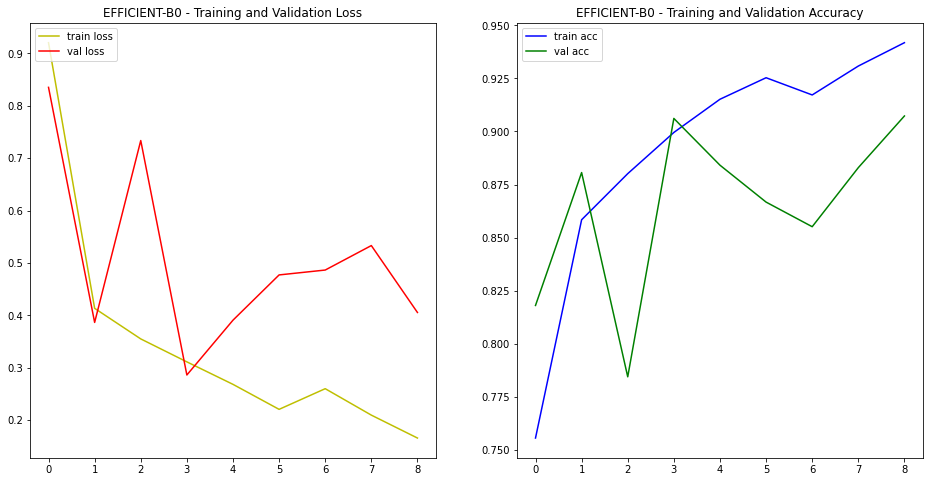

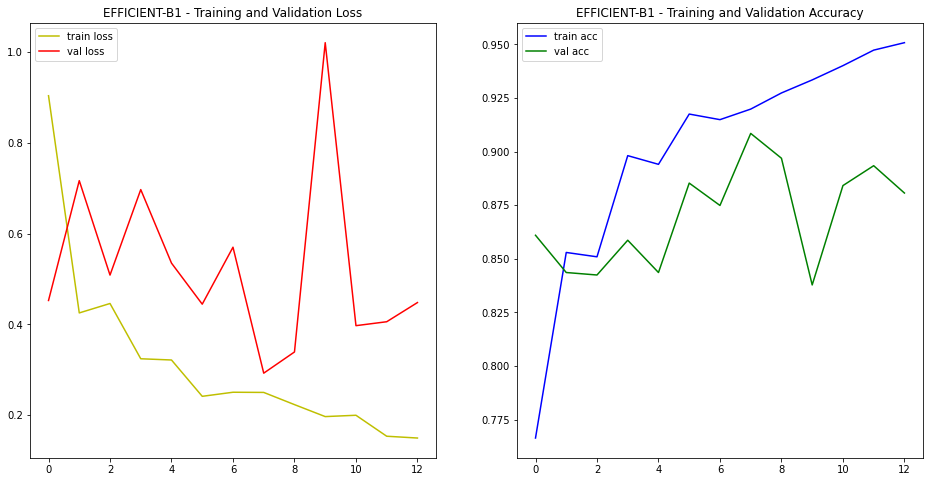

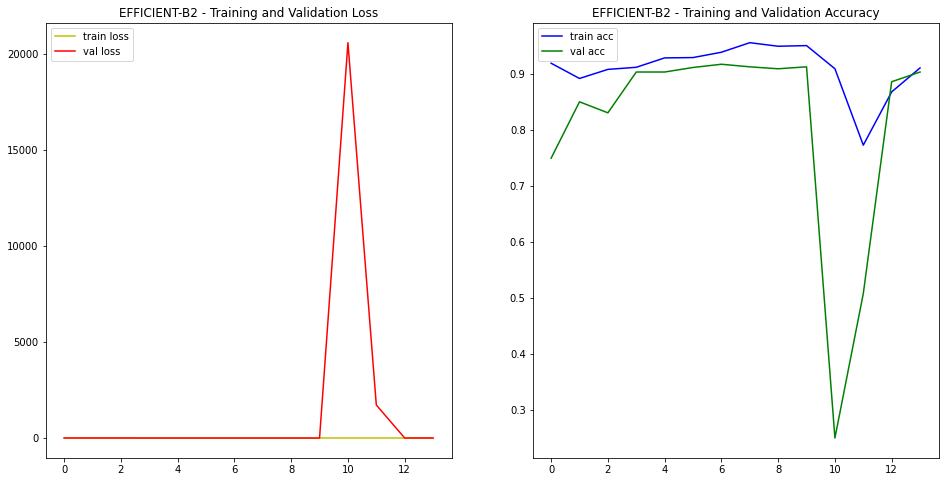

In [ ]:
import matplotlib.pyplot as plt


def efficient_visual(history, model_name):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1) # nrows, ncols, index
  plt.plot(history.history['loss'], 'y', label='train loss')
  plt.plot(history.history['val_loss'], 'r', label='val loss')
  plt.title('{} - Training and Validation Loss'.format(model_name.upper()))
  plt.legend(loc='upper left')

  plt.subplot(1, 2, 2) # nrows, ncols, index
  plt.plot(history.history['accuracy'], 'b', label='train acc')
  plt.plot(history.history['val_accuracy'], 'g', label='val acc')
  plt.title('{} - Training and Validation Accuracy'.format(model_name.upper()))
  plt.legend(loc='upper left')

  plt.show()

  # return plt

def visual(history, model_name):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1) # nrows, ncols, index
  plt.plot(history.history['loss'], 'y', label='train loss')
  plt.plot(history.history['val_loss'], 'r', label='val loss')
  plt.title('{} - Training and Validation Loss'.format(model_name.upper()))
  plt.legend(loc='upper left')

  plt.subplot(1, 2, 2) # nrows, ncols, index
  plt.plot(history.history['categorical_accuracy'], 'b', label='train acc')
  plt.plot(history.history['val_categorical_accuracy'], 'g', label='val acc')
  plt.title('{} - Training and Validation Accuracy'.format(model_name.upper()))
  plt.legend(loc='upper left')

  plt.show()


efficient_visual(history, 'efficient-b0')
efficient_visual(history_b1, 'efficient-b1')
efficient_visual(history_b2, 'efficient-b2')
# efficient_visual(history_b3, 'efficient-b3')
# efficient_visual(history_b4, 'efficient-b4')
# efficient_visual(history_b5, 'efficient-b5')
# efficient_visual(history_b6, 'efficient-b6')
# efficient_visual(history_b6, 'efficient-b7')


# visual(history_ml, 'mobilenetv3-large')
# visual(history_ms, 'mobilenetv3-small')
# visual(history_resnet, 'resnet18')



In [ ]:
# Learning 후 베스트 epoch 확인

n_epochs_best = np.argmax(history) # // hist 중 val_loss 가 가장 낮은 epoch 을 찾아오는 걸까요??
n_epochs_best
print("best : ",n_epochs_best)

best :  0


## 6. 실제 꽃 사진 Load / Test

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# load test flower pictures
img_dir = '/content/flowers_testset'

test_batch_size = 25
test_dataset = tf.keras.utils.image_dataset_from_directory(
    img_dir, 
    labels='inferred', 
    label_mode='categorical',
    batch_size=test_batch_size,
    image_size=(img_height,img_width)
    )

Found 25 files belonging to 5 classes.


In [ ]:
# split(image and labels)
for images, labels in test_dataset:  # only take first element of dataset
    flower_images = images.numpy()
    flower_labels = labels.numpy()

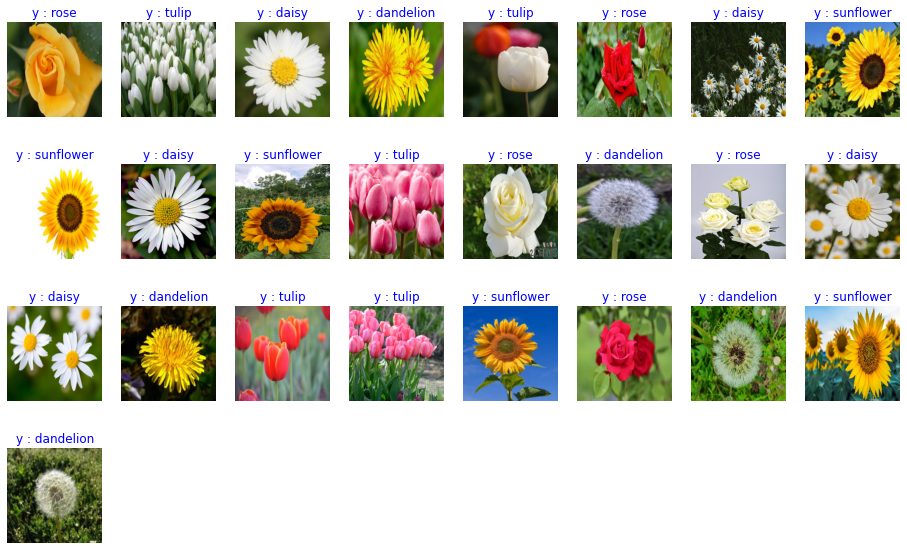

In [ ]:
# Test Set Classification Visulization


class_names = train_dataset.class_names

np.random.seed(10)

sample_batch_size = 25
batch_index = np.random.choice(len(flower_images), size=sample_batch_size, replace=False)

batch_xs = flower_images[batch_index]
batch_ys = flower_labels[batch_index]

# 모델 예측
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (img, y_hat) in enumerate(zip(batch_xs, y_pred_)):
    p = fig.add_subplot(4, 8, i+1)
    # model output으로 one-hot 변환된 y-value를 np.argmax를 통해 index값으로 재변환 한 후 비교
    if np.argmax(y_hat) == np.argmax(batch_ys[i]): # y_hat (예측한 값) 이 정답 label 과 일치한다면, 
        p.set_title("y : {}".format(class_names[np.argmax(y_hat)]), color='blue') # 맞춘경우 Blud
    else:
        p.set_title("y : {}".format(np.argmax(y_hat)), color='red') # 틀린경우 Red
        
    show_img = np.array(img/np.amax(img)*255, np.int32) # 0~255 변환    

  
    p.imshow(show_img)
    p.axis('off') # 축표시제거

## 7. 촬영 꽃 사진으로 도감 일기장 만들기

In [ ]:
import cv2

# Image Brightness Control funciton
def increase_brightness(img, value=50):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def toPaintWithPaper(img1,img2 ,h,w):
    img1 = cv2.xphoto.oilPainting(img1, 7, 5) # 수치크기에 따라 Painting 느낌 증가
    img1 = increase_brightness(img1, value=100)
    rs_img1 = cv2.resize(img1, dsize=(h, w), interpolation=cv2.INTER_AREA) # resize
    rs_img2 = cv2.resize(img2, dsize=(h, w), interpolation=cv2.INTER_AREA) # resize
    img = cv2.addWeighted(rs_img1, 0.7, rs_img2, 0.3, 0.5, dst=None, dtype=None) # 이미지결합
 
    return img


In [ ]:
# Test Image selection
# daisy : 1
# dandelion : 2
# roses : 3
# sunflowers : 4
# tulips : 5
# flower number : 1 ~ 5

flower = 5
flower_number = 1

if flower == 1: flower_sel = "daisy"
elif flower == 2: flower_sel = "dandelion"
elif flower == 3: flower_sel = "roses"
elif flower == 4: flower_sel = "sunflowers"
elif flower == 5: flower_sel = "tulips"
else : flower_sel = "daisy"

flower_path = "C:/JupyterProject/flowers_testset/"+flower_sel+"/"+flower_sel+"_test"+str(flower_number)+".jpg"
print(flower_path)


In [ ]:
img1 = cv2.imread(flower_path)
img2 = cv2.imread('C:/JupyterProject/paper_img/paper3.png')

img = toPaintWithPaper(img1,img2, 480, 480)

cv2.imshow("Flower Original", img1)
cv2.imshow("Flower Paper", img)

cv2.waitKey(0)
cv2.destroyAllWindows()
